In [1]:
#ABILITà Informatiche
#dati Veneto blocco 21

In [1]:
import numpy as np
import imageio
import matplotlib
import scipy
from scipy.optimize import minimize
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import json
import emcee
%matplotlib notebook

In [2]:
indata = open('dpc-covid19-ita-regioni.json')
dati = json.load(indata)

In [3]:
dati[20]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 5,
 'denominazione_regione': 'Veneto',
 'lat': 45.43490485,
 'long': 12.33845213,
 'ricoverati_con_sintomi': 12,
 'terapia_intensiva': 4,
 'totale_ospedalizzati': 16,
 'isolamento_domiciliare': 16,
 'totale_positivi': 32,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 32,
 'dimessi_guariti': 0,
 'deceduti': 1,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 33,
 'tamponi': 2200,
 'casi_testati': None,
 'note': None,
 'ingressi_terapia_intensiva': None,
 'note_test': None,
 'note_casi': None,
 'totale_positivi_test_molecolare': None,
 'totale_positivi_test_antigenico_rapido': None,
 'tamponi_test_molecolare': None,
 'tamponi_test_antigenico_rapido': None,
 'codice_nuts_1': None,
 'codice_nuts_2': None}

In [4]:
len(dati)

21252

In [5]:
data_tot = []
casi_tot = []

for i in range(1012):
    data_tot.append(dati[20 + i*21]['data'])
    casi_tot.append(dati[20 + i*21]['totale_casi'])

<IPython.core.display.Javascript object>


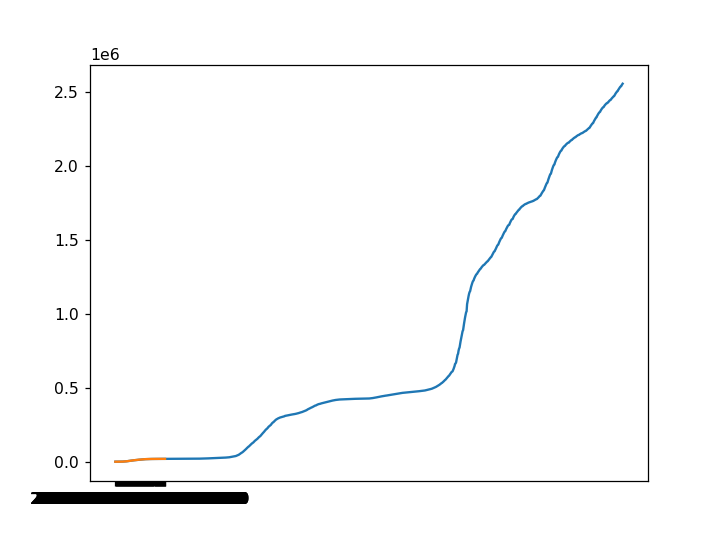

In [6]:
plt.figure()
plt.plot(casi_tot)

In [7]:
data = []
casi = []
N = 100

for i in range(N):
    data.append(dati[20 + i*21]['data'])
    casi.append(dati[20 + i*21]['totale_casi'])
    
plt.plot(data, casi)


In [8]:
#funzione di gompertz

In [137]:
def gompertz(N, t0, ni, b):
    '''
    calcolo della funzione di gompertz per N punti con t0 tempo di inizio, ni plateau della popolazione/dimensione popolazione, 
    b rate di crescita iniziale e n0 popolazione iniziale
    output funzione di gompertz e funzione di gompertz differenziale
    '''
    gomp = np.zeros(N)
    for t in range(N):
        gomp[t] = np.exp( np.log(ni) * ( 1 - np.exp( -b * (t-t0) ) ) )

    gomp_diff = np.zeros(N-1)
    for t in range(N-1):
            gomp_diff[t] = gomp[t+1] - gomp[t]
            
    return gomp, gomp_diff

<IPython.core.display.Javascript object>


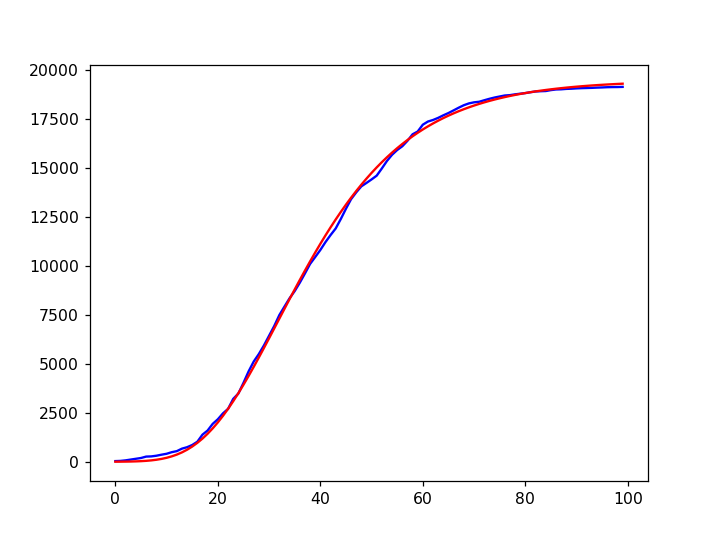

In [10]:
#prova con casi
t0 = -1
b = 0.07
ni = 19500

prova, diff = gompertz(N, t0, ni, b)

dati_casi = [x for x in casi]

plt.figure()
plt.plot(dati_casi, color='blue')
plt.plot(prova, color='red')

In [11]:
#poisson likelihood

In [12]:
def log_likelihood(dati, predizione):
    '''
    calcolo del logaritmo poisson-likelihood per i dati usando come modello predizione (entrambi array) 
    '''
    # -log(likelihood) = L
    L = -np.sum(-np.log(predizione)*dati + predizione )
        
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    return L

<IPython.core.display.Javascript object>


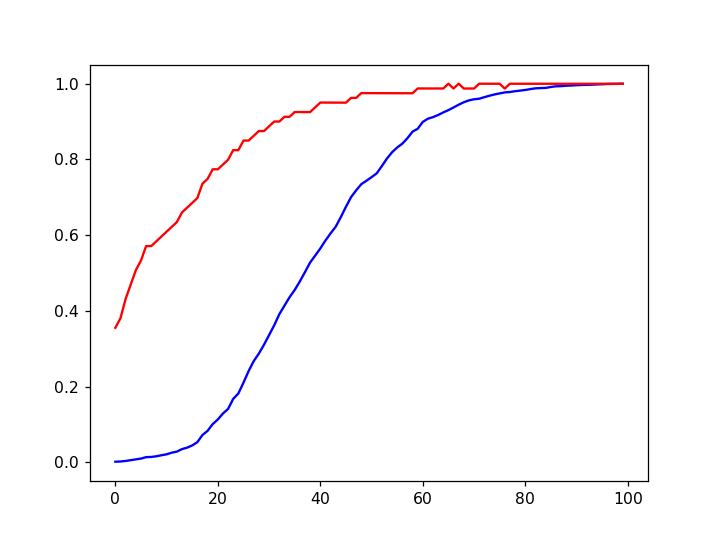

In [102]:
#prova casi
stima = prova

sol = minimize(log_likelihood, stima, dati_casi)

dati_nor = [x/max(dati_casi) for x in dati_casi]

sol_nor = sol.x/min(sol.x)

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol_nor, color='red')

In [15]:
#emcee guida(https://emcee.readthedocs.io/en/stable/)

In [226]:
def log_probability(dati, predizione):
    N = len(dati)
    lp = scipy.stats.poisson.pmf(range(N), 30)
    return lp + log_likelihood(dati, predizione)

In [227]:
pos = sol1.x + 1e-4 * np.random.randn(32, N)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability(dati, sol1.x), stima1)

sampler.run_mcmc(pos, 100, progress=True);

C:\Users\march\AppData\Local\Temp\ipykernel_14012\3245158710.py:6: RuntimeWarning: invalid value encountered in log
  L = -np.sum(-np.log(predizione)*dati + predizione )


AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [210]:
sampler.run_mcmc?

In [211]:
emcee.EnsembleSampler?

In [138]:
def log_likelihood_gompertz(theta, dati):
    '''
    calcolo del logaritmo poisson-likelihood per i dati (array) usando come modello la funzione di gompertz (vedi fun gompertz) 
    '''
    t0, ni, b = theta
    N = len(dati)
    modello, dif = gompertz(N, t0, ni, b)
    
    # -log(likelihood) = L
    L = -np.sum(np.log(modello)*dati - modello )   
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    
    return L

0 18708.450412719998 0.6075448519014384


<IPython.core.display.Javascript object>


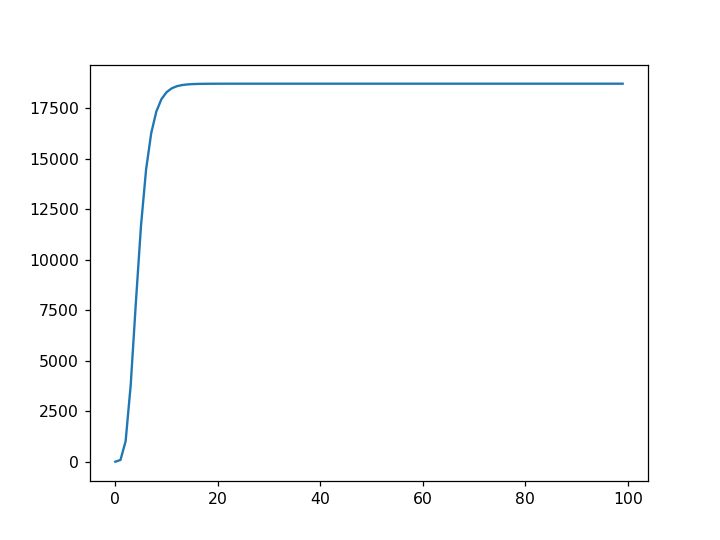

In [139]:
#np.random.seed(7)
t0 = -np.random.randint(0, 5)
ni = max(casi) + 500 * np.random.uniform(-1,1)
b = np.random.uniform()

modello, diff_modello = gompertz(N, t0, ni, b)

print(t0, ni, b)

plt.figure()
plt.plot(modello)

[-4.74460877e+00  1.99949550e+04  6.21608149e-02]
[0.00000000e+00 1.88141262e+04 9.62346809e-02]


C:\Users\march\AppData\Local\Temp\ipykernel_10888\403487489.py:10: RuntimeWarning: divide by zero encountered in log
  L = -np.sum(np.log(modello)*dati - modello )
C:\Users\march\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\march\AppData\Local\Temp\ipykernel_10888\403487489.py:10: RuntimeWarning: divide by zero encountered in log
  L = -np.sum(np.log(modello)*dati - modello )
C:\Users\march\AppData\Local\Temp\ipykernel_10888\403487489.py:10: RuntimeWarning: divide by zero encountered in log
  L = -np.sum(np.log(modello)*dati - modello )
C:\Users\march\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\march\AppData\Local\Temp\ipykernel_10888\403487489.py:10: RuntimeWarning: divide by zero encountered in log
  L = -np.sum(np.log(modello)*dati - modello )


<IPython.core.display.Javascript object>


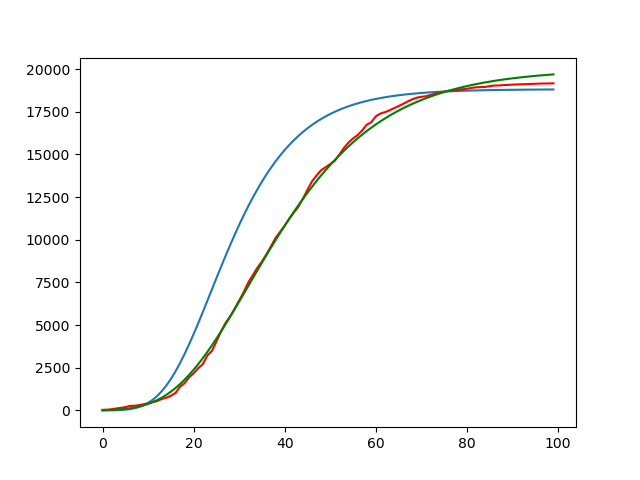

In [204]:
nll = lambda *args: log_likelihood_gompertz(*args)
dati = [x for x in casi]

t0 = -np.random.randint(0, 5)
ni = max(dati) + 500 * np.random.uniform(-0.9,0.9)
b = np.random.uniform(0.05, 0.1)
parametri = np.array([t0, ni, b])

soln = minimize(nll, parametri, args=(dati))
print(soln.x)
print(parametri)
t01, ni1, b1 = soln.x

modello, diff_modello = gompertz(N, t0, ni, b)
modello1, diff_modello = gompertz(N, t01, ni1, b1)

plt.figure()
plt.plot(modello)
plt.plot(dati, color='red')
plt.plot(modello1, color='green')